# Import Libraries

In [0]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images
import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary

#DataTransforms 


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transforms = transforms.Compose([
                                    #    transforms.Resize((32, 32)), # all the data is already in this shape
                                       transforms.RandomAffine(degrees=10, shear = 10),
                                       transforms.ToTensor() ,
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#CUDA?

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


plane   dog  deer  deer


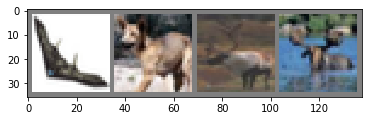

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #Convolution Block #1
        self.conv1 = conv_block(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation=2, bias=False)      
        #input :32x32x3    k=3x3  kernel_size=32(3x3x3x32)  output=32x32x32      RF:5    
        self.conv2 = conv_block(in_channels=32, out_channels=64, kernel_size=3, padding=2, dilation=2, dropout=0.1,  bias=False)     
        #input:32x32x32   k=3x3 , kernel_size=64(3x3x32x64)     output=32x32x64      RF:9 

        #MaxPool #1
        self.pool = nn.MaxPool2d(2, 2)                                                                                  
        #input:32x32x64   k=2x2 kernel_size=2 output=16x16x64      RF:10

        #ConvolutionBlock #2
        self.conv3 = conv_block(in_channels=64, out_channels=64*3, kernel_size=3, padding=1, bias=False, groups=64)     
      
        #input:16x16x64   k=3x3  kernel_size=32((3x3x1)64x3)  output=16x16x(64*3)     RF:14       
       
        self.conv4 = conv_block(in_channels=64*3, out_channels=128, kernel_size=1, bias=False)   
        #input:16x16x(64*3)   k=1x1 kernel_size=128(1x1x32x128)  output=16x16x128     RF:14

        #maxpool #2
        self.pool = nn.MaxPool2d(2, 2) 
        #input:16x16x128   k=2x2 , output=8x8x128      RF:16

        #convolution Block#3
        self.conv5 = conv_block(in_channels=128, out_channels=32, kernel_size=1, dropout=0.1, bias=False)                 
        #input:8x8x128   k=1x1 ,kernel_size=32(3x3x1x32)   output=8x8x32     RF:16

        self.conv6 = conv_block(in_channels=32, out_channels=64, kernel_size=3, dropout=0.1, padding=1, bias=False)                  
        #input:8x8x32    k=3x3 kernel_size=64(3x3x32x64)  output=8x8x64     RF:24

        self.conv7 = conv_block(in_channels=64, out_channels=128, kernel_size=3, dropout=0.2, padding=1, bias=False)                
         #input:8x8x64   k=3x3 ,kerenel_size=128(3x3x64x128) output=8x8x128    RF:32

        #maxpool #2
        self.pool = nn.MaxPool2d(2, 2)                                                                                 
         #input:8x8x128   k=2x2 ,kerenel_size=2   output=4x4x128    RF:36

        
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, bias=False)                 
         #input:4x4x128  k=3x3 kernel_size=64    output:4x4x64    RF:42
        self.gap = nn.AvgPool2d(kernel_size=4)            
         #input:4x4x64   k=4 , kernel_size=4,      output:1x1x64    RF:46
        self.final = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1, bias=False) 
         #input:1x1x64   k=1, kernel_size=10    o:1x1x10    RF:60

    def forward(self, x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.pool(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.pool(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=self.conv7(x)
        x=self.pool(x)
        x=self.conv8(x)
        x=self.gap(x)
        x=self.final(x)
        x = x.view(-1, 10)                           
        return F.log_softmax(x)


        

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 192, 16, 16]           1,728
      BatchNorm2d-11          [-1, 192, 16, 16]             384
             ReLU-12          [-1, 192, 16, 16]               0
          Dropout-13          [-1, 192, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate (pbar):
    data, target = data.to(device), target.to(device)

    #Don't want history of gradients 
    optimizer.zero_grad()

    y_predict = model(data)

    # Caluclate loss
    loss = F.nll_loss(y_predict, target)
    train_losses.append(loss)

    # Back propogate error
    loss.backward()

    # Take a optimzer step
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_predict.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.4f}')
    train_acc.append(100*correct/processed)


def test (model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model =  Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

cuda


In [0]:
EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    # scheduler.step()
    test(model, device, test_loader)


    

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.077009916305542 Batch_id=781 Accuracy=45.9040: 100%|██████████| 782/782 [00:19<00:00, 40.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3963, Accuracy: 4911/10000 (49.11%)

EPOCH: 1


Loss=1.5462054014205933 Batch_id=781 Accuracy=59.6780: 100%|██████████| 782/782 [00:19<00:00, 40.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1065, Accuracy: 5987/10000 (59.87%)

EPOCH: 2


Loss=1.223622441291809 Batch_id=781 Accuracy=64.4560: 100%|██████████| 782/782 [00:19<00:00, 40.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9824, Accuracy: 6491/10000 (64.91%)

EPOCH: 3


Loss=0.616654098033905 Batch_id=781 Accuracy=67.3400: 100%|██████████| 782/782 [00:19<00:00, 41.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8610, Accuracy: 7023/10000 (70.23%)

EPOCH: 4


Loss=1.5552135705947876 Batch_id=781 Accuracy=69.7820: 100%|██████████| 782/782 [00:18<00:00, 41.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8765, Accuracy: 6957/10000 (69.57%)

EPOCH: 5


Loss=0.7962995171546936 Batch_id=781 Accuracy=71.3360: 100%|██████████| 782/782 [00:18<00:00, 41.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8276, Accuracy: 7064/10000 (70.64%)

EPOCH: 6


Loss=0.4085195064544678 Batch_id=781 Accuracy=72.8680: 100%|██████████| 782/782 [00:18<00:00, 41.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7373, Accuracy: 7424/10000 (74.24%)

EPOCH: 7


Loss=0.8509893417358398 Batch_id=781 Accuracy=74.2040: 100%|██████████| 782/782 [00:18<00:00, 41.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7105, Accuracy: 7534/10000 (75.34%)

EPOCH: 8


Loss=0.9079614877700806 Batch_id=781 Accuracy=74.8460: 100%|██████████| 782/782 [00:18<00:00, 42.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6719, Accuracy: 7710/10000 (77.10%)

EPOCH: 9


Loss=1.218879222869873 Batch_id=781 Accuracy=76.2400: 100%|██████████| 782/782 [00:18<00:00, 42.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6823, Accuracy: 7659/10000 (76.59%)

EPOCH: 10


Loss=0.8687474727630615 Batch_id=781 Accuracy=76.9040: 100%|██████████| 782/782 [00:18<00:00, 49.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6819, Accuracy: 7613/10000 (76.13%)

EPOCH: 11


Loss=0.9157772064208984 Batch_id=781 Accuracy=77.5780: 100%|██████████| 782/782 [00:18<00:00, 42.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6705, Accuracy: 7682/10000 (76.82%)

EPOCH: 12


Loss=0.7903655767440796 Batch_id=781 Accuracy=78.3640: 100%|██████████| 782/782 [00:18<00:00, 43.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6274, Accuracy: 7792/10000 (77.92%)

EPOCH: 13


Loss=1.3569997549057007 Batch_id=781 Accuracy=78.6220: 100%|██████████| 782/782 [00:18<00:00, 43.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5996, Accuracy: 7919/10000 (79.19%)

EPOCH: 14


Loss=0.4636343717575073 Batch_id=781 Accuracy=79.3860: 100%|██████████| 782/782 [00:18<00:00, 49.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6074, Accuracy: 7886/10000 (78.86%)

EPOCH: 15


Loss=0.746337354183197 Batch_id=781 Accuracy=79.9940: 100%|██████████| 782/782 [00:18<00:00, 42.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5849, Accuracy: 8013/10000 (80.13%)

EPOCH: 16


Loss=0.39123770594596863 Batch_id=781 Accuracy=80.3580: 100%|██████████| 782/782 [00:18<00:00, 43.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5967, Accuracy: 7942/10000 (79.42%)

EPOCH: 17


Loss=1.6448001861572266 Batch_id=781 Accuracy=80.8600: 100%|██████████| 782/782 [00:18<00:00, 43.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6407, Accuracy: 7760/10000 (77.60%)

EPOCH: 18


Loss=0.7878073453903198 Batch_id=781 Accuracy=80.9760: 100%|██████████| 782/782 [00:17<00:00, 43.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5700, Accuracy: 8031/10000 (80.31%)

EPOCH: 19


Loss=0.3221472501754761 Batch_id=781 Accuracy=81.5720: 100%|██████████| 782/782 [00:17<00:00, 44.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6106, Accuracy: 7866/10000 (78.66%)

EPOCH: 20


Loss=0.7409795522689819 Batch_id=781 Accuracy=81.6980: 100%|██████████| 782/782 [00:17<00:00, 44.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5734, Accuracy: 8044/10000 (80.44%)

EPOCH: 21


Loss=0.5788601040840149 Batch_id=781 Accuracy=82.3440: 100%|██████████| 782/782 [00:17<00:00, 44.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5594, Accuracy: 8043/10000 (80.43%)

EPOCH: 22


Loss=0.23768189549446106 Batch_id=781 Accuracy=82.2780: 100%|██████████| 782/782 [00:17<00:00, 43.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5462, Accuracy: 8105/10000 (81.05%)

EPOCH: 23


Loss=0.590128481388092 Batch_id=781 Accuracy=82.8580: 100%|██████████| 782/782 [00:17<00:00, 44.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5404, Accuracy: 8142/10000 (81.42%)

EPOCH: 24


Loss=0.5686523914337158 Batch_id=781 Accuracy=82.8520: 100%|██████████| 782/782 [00:17<00:00, 44.64it/s]



Test set: Average loss: 0.5525, Accuracy: 8099/10000 (80.99%)



Text(0.5, 1.0, 'Test Accuracy')

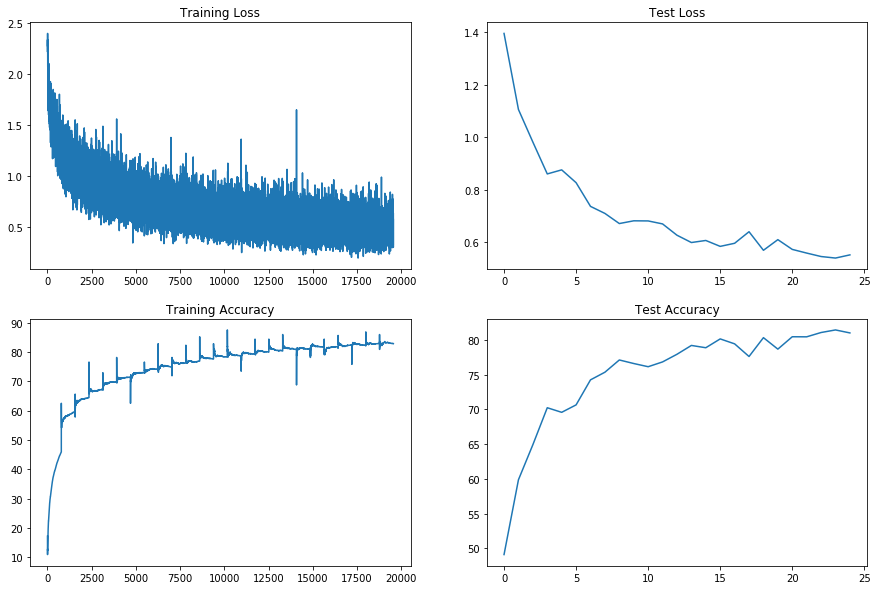

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")